## Description
In this notebook, we use a reference image (manually generated in GIMP) to generate a simulated mass spectrometric (MS) image with overlapping isotopic envelopes. We will manually define the molecular formulas of the ions and their proportions in each region of the image.     
We will simulate pixel-to-pixel variability in the MS image and measurement inaccuracies in individual spectra, including background noise.   

We will then perform regression of spectra using `masserstein`.      

Finally, we will compare four segmentation approaches: either based on peaks or `masserstein` estimates, and either using K-means or `spatial-DGMM` algorithms.  

Simulation steps:  
1. Generate reference spectra for different regions of the image using manually defined proportions
2. For each pixel: 
  1. Sample numbers of ions for each molecule, with an average value depending on the region of the image, and a constant coefficient of variance; 
  2. Distort each spectrum by sampling from the multinomial process with the number of molecules given by the corresponding distorted proportion; 
  3. Combine the distorted spectra; 
  4. Add a handful of noise peaks amounting for 5% of the total signal to simulate contaminants; 
  5. Apply a Gaussian filter to the spectra to lower the resolution; 
  6. Apply a Gaussian distortion to each intensity measurement to simulate electronic noise; 
  7. Centroid the spectrum.  

The result will be stored in imzML files for the profile and the centroided spectra.  

## Python modules

In [1]:
%matplotlib inline

In [2]:
import imageio
import numpy as np
import numpy.random as rd 
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
from pyimzml.ImzMLWriter import ImzMLWriter
from pyimzml.ImzMLParser import ImzMLParser
from copy import deepcopy
from scipy.stats import nbinom, pearsonr
from sklearn.cluster import KMeans
import pandas as pd

## Loading and preparation of the reference image

Load the reference "optical" image: 

In [3]:
mask = imageio.imread('SimulationMask.png')

/tmp/ipykernel_8523/3487602934.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread('SimulationMask.png')


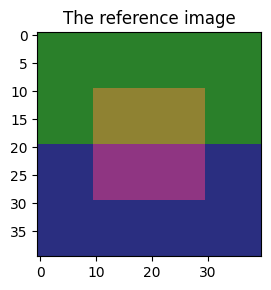

In [4]:
plt.figure(figsize=(3,3))
plt.title('The reference image')
plt.imshow(mask)
plt.tight_layout()
plt.show()

The image contains four regions corresponding to four different colors.   
Parse the image into four `numpy` arrays corresponding to each region:  

In [5]:
region1 = mask[:,:,1] == 128
region2 = mask[:,:,1] == 46
region3 = mask[:,:,1] == 130
region4 = mask[:,:,1] == 53

Generate a two-dimentional array storing the region index for each pixel:  

In [6]:
region_mapping = np.zeros(mask.shape[:2], dtype='int')
for reg_id, reg_value in enumerate([128, 46, 130, 53]):
    region_mapping[mask[:,:,1] == reg_value] = reg_id

Visualize individual regions:

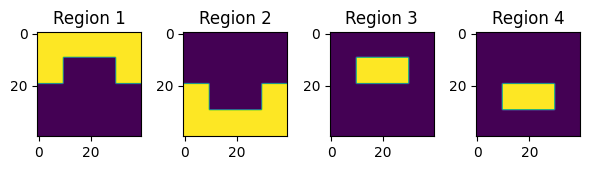

In [7]:
plt.figure(figsize=(6,2))
plt.subplot(141)
plt.title('Region 1')
plt.imshow(region1)
plt.subplot(142)
plt.title('Region 2')
plt.imshow(region2)
plt.subplot(143)
plt.title('Region 3')
plt.imshow(region3)
plt.subplot(144)
plt.title('Region 4')
plt.imshow(region4)
plt.tight_layout()
plt.show()

Show the combined regions:

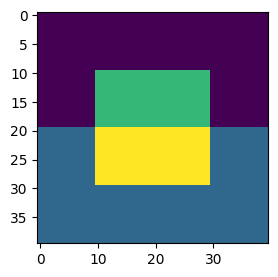

In [8]:
plt.figure(figsize=(3,3))
plt.imshow(region_mapping)
plt.show()

Compute the region areas:

In [9]:
region_areas = [np.sum(region_mapping==i) for i in range(4)]
print('Areas of regions in numbers of pixels:', region_areas)
assert sum(region_areas) == region_mapping.shape[0]*region_mapping.shape[1]

Areas of regions in numbers of pixels: [600, 600, 200, 200]


Generate masks of the top and bottom rectangles and the central square:

In [10]:
enrichment_mask = np.zeros(mask.shape[:2] + (3,), dtype='bool')
enrichment_mask[...,0] = region1 + region3
enrichment_mask[...,1] = region2 + region4
enrichment_mask[...,2] = region3 + region4

Optional: load the image from previous notebook run:

In [11]:
# profile_imzml = ImzMLParser('lipid_MSI_profile_mode.imzML')
# image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
# for idx, (xcoord,ycoord,zcoord) in enumerate(profile_imzml.coordinates):
#     mz, intsy = profile_imzml.getspectrum(idx)
#     mz, intsy = np.array(mz), np.array(intsy)
#     image[ycoord,xcoord,...] = intsy

## Preparation of theoretical spectra

We will generate theoretical spectra of three lipids for use as references in the simulations

In [12]:
lipid_names = ['PC(38:1)', 'PA(44:0)', 'PC(38:0)']
lipid_formulas = ['C46H90NO8P', 'C47H93O8P', 'C46H92NO8P']

In [13]:
spectra = [Spectrum(f, adduct='K', threshold=0.001, label=n) for f, n in zip(lipid_formulas, lipid_names)]
for s in spectra:
    s.normalize()

Monoisotopic peaks of the lipids:

In [14]:
for s in spectra:
    print(s.label, s.confs[0][0], sep=': ')

PC(38:1): 854.6041123617
PA(44:0): 855.62451345431
PC(38:0): 856.61976242624


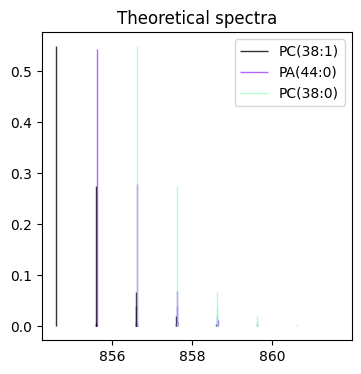

In [15]:
plt.figure(figsize=(4,4))
plt.title('Theoretical spectra')
Spectrum.plot_all(spectra)
plt.show()

## Image simulation

### Intensity averages

Generate a 4x3 array of average ion counts of the three lipids in the four regions.   
The array is constructed so that the isotopic peak of PC(38:1) overshadows the monoisotopic peak of PA(44:0).  

In [16]:
average_ion_counts = np.array([
    [1e04, 2e03, 1e03],
    [1e03, 4e03, 1e03],
    [1e04, 2e03, 2e03],
    [1e03, 4e03, 2e03]
], dtype='int')

Show the true distribution of lipid concentrations:

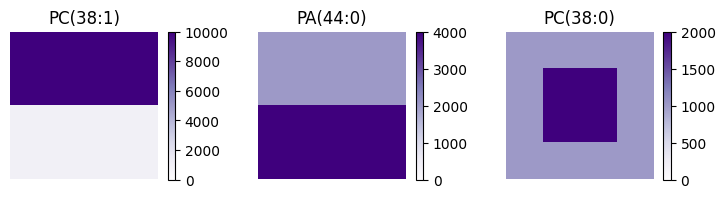

In [17]:
plt.figure(figsize=(7.5, 2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(131 + lipid_id)
    spatial_intensity = average_ion_counts[region_mapping, lipid_id]
    plt.imshow(spatial_intensity, cmap=cm.Purples, vmin=0)
    plt.title(lipid_name)
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/simulations/lipid_enrichment_plot.png', dpi=500)

We'll now visualize the reference spectra (in profile mode) of the four image regions.  
First, define the mass axis for spectra in profile mode:

In [18]:
mass_axis = np.arange(854, 860, 0.01)

Define the peak width (in terms of standard deviation of a Gaussian): 

In [19]:
peak_sd = 0.05

In [20]:
2.355*peak_sd # FWHM

0.11775000000000001

In [21]:
800/(2.355*peak_sd)

6794.055201698513

Generate theoretical profile spectra:  

In [22]:
profile_spectra = [deepcopy(s) for s in spectra]
for i, ps in enumerate(profile_spectra):
    ps.gaussian_smoothing(peak_sd, 0.01)
    profile_spectra[i] = ps.resample(mass_axis)

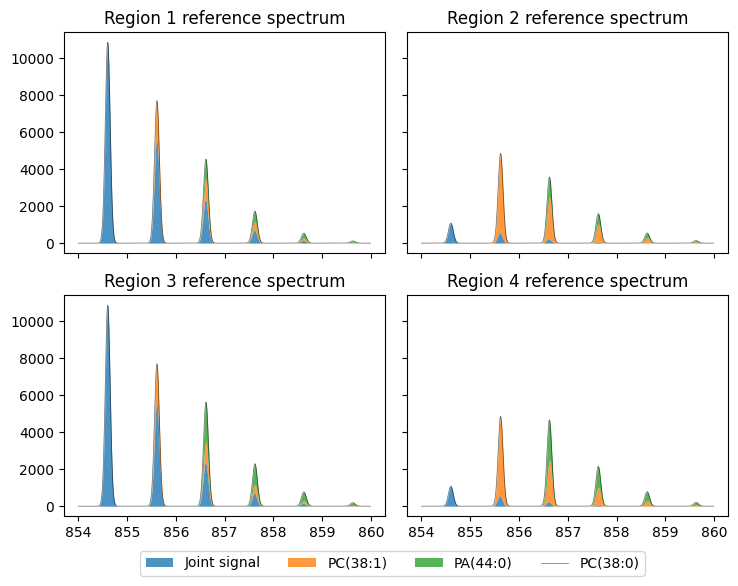

In [23]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7.5, 5.6))

for i in range(average_ion_counts.shape[0]):
    plt.subplot(221 + i)
    plt.title('Region %i reference spectrum' % (i+1))
    cumulative_intensity = np.zeros(mass_axis.shape)
    for j in range(average_ion_counts.shape[1]):
        ions = average_ion_counts[i, j]/4
        current_intensity = np.array([i*ions for m, i in profile_spectra[j].confs])
        plt.fill_between(mass_axis, 
                         cumulative_intensity, 
                         current_intensity+cumulative_intensity,
                         facecolor=cmap(j, alpha=0.8), edgecolor=(0,0,0,0))
        cumulative_intensity += current_intensity
    plt.plot(mass_axis, cumulative_intensity, color='k', alpha=0.6, lw=0.5)
lgd = fig.legend(['Joint signal'] + lipid_names, loc='lower center', bbox_to_anchor=(.53, -.05), ncol=4)
plt.tight_layout()
plt.savefig('Figs/simulations/region_rainbow_reference.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=500)

Note that the monoisotopic peak of PA(44:0) at 855.6 is higher in region 1 than in region 2 due to the contribution of PC(38:1) to its intensity.  

### Intensity variances 

Calculate standard deviations of ion molecules for a fixed coefficient of variance, for a peak with intensity 0.5:

In [24]:
coefficient_of_variance = 0.4
ion_count_variance = average_ion_counts**2*coefficient_of_variance**2 - average_ion_counts
np.sqrt(ion_count_variance)

array([[3998.74980463,  798.74902191,  398.74804075],
       [ 398.74804075, 1598.74951134,  398.74804075],
       [3998.74980463,  798.74902191,  798.74902191],
       [ 398.74804075, 1598.74951134,  798.74902191]])

### Whole image simulation

We'll simulate each pixel independently.   
In each pixel, we'll draw the number of ions of each lipid from the negative binomial distribution, with the average and variance given by `average_ion_counts` and `ion_count_variance`.  
Next, we'll combine the theoretical spectra of the three lipids in proportions given by the drawn numbers of ions.  
Next, we'll add a given number of randomly located peaks to simulate additional confounding signals. The number of added peaks is controlled by the `nb_of_noise_peaks` variable, and the total proportion of signal in the spectrum that they will correspond to is controlled by the `noise_proportion` variable.   
Next, we'll apply a Gaussian filter with standard deviation given by the `peak_sd` variable defined earlier, to get spectra in profile mode.   
Finally, we'll resample the spectrum so that the m/z measurements correspond to `mass_axis` defined earlier.   

In [25]:
nb_of_noise_peaks = 10
noise_proportion = 0.1

In [26]:
image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
true_ion_image = np.zeros((mask.shape[0], mask.shape[1], len(spectra)), dtype='int')
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        region_id = region_mapping[i, j]
        ion_counts = average_ion_counts[region_id]
        count_vars = ion_count_variance[region_id]
        nbinom_p = ion_counts/count_vars
        nbinom_n = ion_counts**2/(count_vars-ion_counts)
        pixel_spectrum = Spectrum()
        for s_id, s, p, n in zip(range(len(spectra)), spectra, nbinom_p, nbinom_n):
            nb_of_ions = nbinom.rvs(p=p, n=n)
            s = Spectrum.sample_multinomial(s, nb_of_ions, 1, 0.001)
            pixel_spectrum += s
            true_ion_image[i,j,s_id] = nb_of_ions
        pixel_spectrum.add_chemical_noise(nb_of_noise_peaks, noise_proportion)
        pixel_spectrum.gaussian_smoothing(peak_sd, 0.01)
        pixel_spectrum = pixel_spectrum.resample(mass_axis)
        pixel_spectrum.set_confs([c for c in pixel_spectrum.confs if c[1] >= 0])
        image[i,j,:] = [y for x,y in pixel_spectrum.confs]

Inspect the pixel-to-pixel variability of ion counts

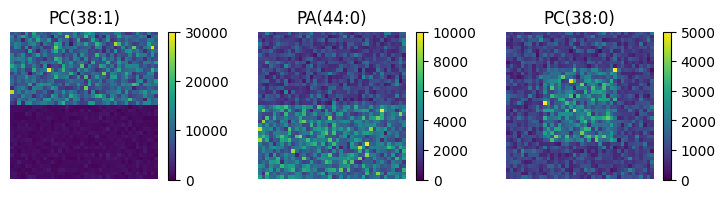

In [27]:
plt.figure(figsize=(7.5, 2))
vmax_vals = [30000, 10000, 5000]
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(131 + lipid_id)
    plt.imshow(true_ion_image[..., lipid_id], vmin=0, vmax=vmax_vals[lipid_id])
    plt.title(lipid_name)
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/simulations/true_ion_plot.png', dpi=500)

### Calculating the monoisotopic peak areas in the simulated image

Manually defined regions for integration of the monoisotopic peaks:  
(we could as well centroid the pixel spectra and then select the monoisotopic peaks, but this is a faster way that gives the same results) 

In [28]:
integration_regions = [
    (854.4, 854.8),
    (855.4, 855.8),
    (856.4, 856.8)
]

In [29]:
integrated_peak_areas = np.zeros(mask.shape[:2] + (len(integration_regions), ))
for peak_id, peak_region in enumerate(integration_regions):
    areas = np.zeros(mask.shape[:2])
    for i in range(areas.shape[0]):
        for j in range(areas.shape[1]):
            intsy = image[i, j]
            to_take = (mass_axis >= peak_region[0])*(mass_axis <= peak_region[1])
            areas[i,j] = np.trapz(intsy[to_take], mass_axis[to_take])
    integrated_peak_areas[:,:,peak_id] = areas

## Verification of the simulation results

Example simulated spectra:

In [30]:
selected_coords = [next(zip(*np.where(region_mapping==i))) for i in range(4)]

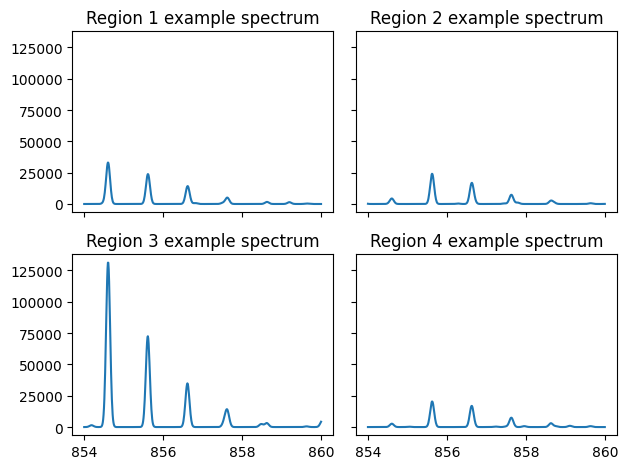

In [31]:
plt.subplots(2, 2, sharex=True, sharey=True)
for i, crd in enumerate(selected_coords):
    plt.subplot(221+i)
    plt.title('Region %i example spectrum' % (i+1))
    plt.plot(mass_axis, image[crd])
plt.tight_layout()
plt.savefig('Figs/simulations/region_example.png', dpi = 300)

Generate peak intensity images:

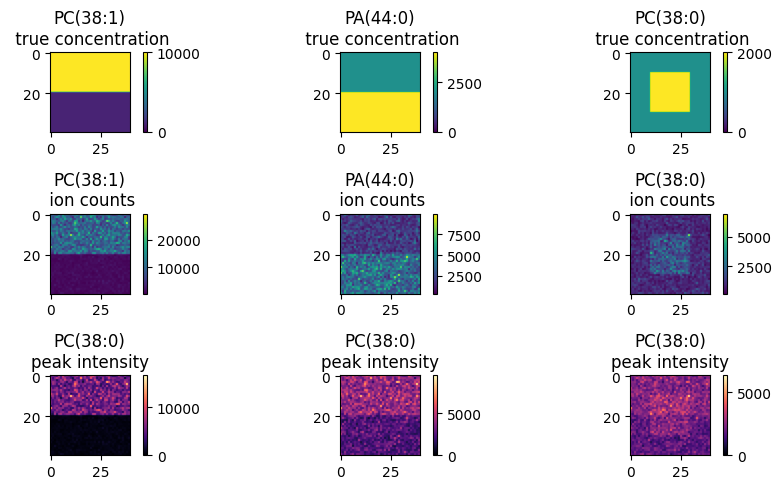

In [32]:
plt.subplots(3, 3, figsize=(9, 5))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(3, 3, 1 + lipid_id)
    spatial_intensity = average_ion_counts[region_mapping, lipid_id]
    plt.imshow(spatial_intensity, vmin=-1) # , vmin=-1, vmax=10000)
    plt.title(lipid_name + '\n true concentration')
    plt.colorbar()
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(3, 3, 4 + lipid_id)
    spatial_intensity = true_ion_image[..., lipid_id]
    plt.imshow(spatial_intensity) # , vmin=-1, vmax=10000)
    plt.title(lipid_name + '\n ion counts')
    plt.colorbar()
for peak_id, peak_region in enumerate(integration_regions):
    plt.subplot(3, 3, 7 + peak_id)
    plt.title(lipid_name + '\npeak intensity')
    plt.imshow(integrated_peak_areas[..., peak_id], cmap=cm.magma, vmin=-1)# , vmin=-1, vmax=8000)
    plt.colorbar()
plt.tight_layout()

We can already appreciate the effect of peak overlaps and pixel-to-pixel variability.  

Visualize the distribution of peak areas for each lipid:

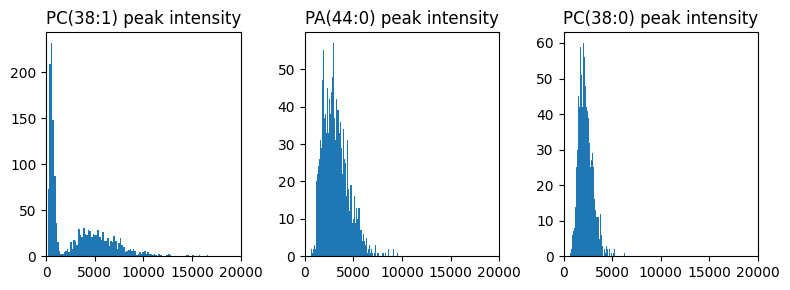

In [33]:
plt.subplots(1, 3, figsize=(8,3))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(131 + lipid_id)
    plt.xlim(0, 20000)
    plt.title(lipid_name + ' peak intensity')
    plt.hist(integrated_peak_areas[:,:,lipid_id].reshape((-1,)), bins=100)
plt.tight_layout()

## Deconvolving the simulated pixel spectra

We'll quantify the amount of signal of each lipid in each pixel spectrum.   
Not that we'll quantify the total signal of each lipid (i.e. it's going to be proportional to the total ion current in the analyzed spectrum) rather than the proportion of the signal (i.e. a relative concentration of each lipid).   

In [34]:
estimated_lipid_signals = np.zeros(mask.shape[:2] + (len(spectra), ))
# # If we want to quantify signals directly from the profile-mode spectra (without centroiding):
# profile_estimated_lipid_signals = np.zeros(mask.shape[:2] + (len(spectra), ))
for xid in range(mask.shape[0]):
    for yid in range(mask.shape[1]):
        intensity = image[xid, yid]
        TIC = np.trapz(intensity, mass_axis)
        s = Spectrum(confs=list(zip(mass_axis, intensity)))
        # # If we want to quantify signals directly from the profile-mode spectra (without centroiding):
        # s.normalize()
        # regression = estimate_proportions(s, spectra, progress=False, MTD=0.2)
        # proportions = np.array(regression['proportions'])
        # signals = proportions*TIC
        # profile_estimated_lipid_signals[xid, yid] = signals
        
        # Centroid the spectrum & regress against the theoretical spectra: 
        s = Spectrum(confs=s.centroid(max_width=0.4, peak_height_fraction=0.2)[0])
        s.normalize()
        regression = estimate_proportions(s, spectra, progress=False, MTD=0.2)
        proportions = np.array(regression['proportions'])
        # Multiply the estimated proportions of lipids by the total ion current
        # to obtain the estimated signal contributions:  
        signals = proportions*TIC
        estimated_lipid_signals[xid, yid] = signals

Compare the estimated signal with the monoisotopic peak area and the true distribution of the lipids:   

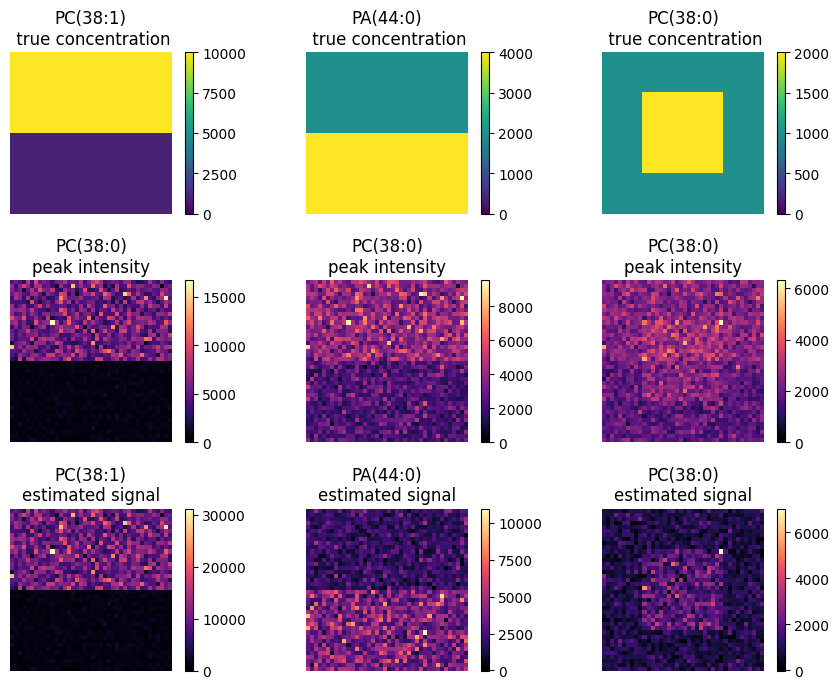

In [35]:
plt.subplots(3, 3, figsize=(9, 7))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(3, 3, 1 + lipid_id)
    spatial_intensity = average_ion_counts[region_mapping, lipid_id]
    plt.imshow(spatial_intensity, vmin=-1) 
    plt.axis('off')
    plt.title(lipid_name + '\n true concentration')
    plt.colorbar()
for peak_id, peak_region in enumerate(integration_regions):
    plt.subplot(3, 3, 4 + peak_id)
    plt.title(lipid_name + '\npeak intensity')
    plt.imshow(integrated_peak_areas[..., peak_id], cmap=cm.magma, vmin=-1)
    plt.axis('off')
    plt.colorbar()
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(3, 3, 7 + lipid_id)
    plt.imshow(estimated_lipid_signals[...,lipid_id], cmap=cm.magma, vmin=-1)
    plt.title(lipid_name + '\nestimated signal')
    plt.axis('off')
    plt.colorbar()    
    
plt.tight_layout()
plt.savefig('Figs/simulations/peak_vs_signal.png', dpi=600)

Calculate the correlation between the true number of ions and the estimated signals:

In [49]:
for lipid_id, lipid_name in enumerate(lipid_names):
    true_mat = true_ion_image[..., lipid_id]
    peak_area = integrated_peak_areas[..., lipid_id]
    mass_estim = estimated_lipid_signals[...,lipid_id]
    # scaling for correlation
    true_mat = true_mat - np.mean(true_mat)
    true_mat /= np.std(true_mat)
    peak_area -= np.mean(peak_area)
    peak_area /= np.std(peak_area)
    mass_estim -= np.mean(mass_estim)
    mass_estim /= np.std(mass_estim)
    # correlations:
    peak_corr = np.mean(true_mat*peak_area)
    mass_corr = np.mean(true_mat*mass_estim)
    print(lipid_name, 'peak correlation:', peak_corr, 'masserstein correlation:', mass_corr)

PC(38:1) peak correlation: 0.9994912775860192 masserstein correlation: 0.9989894759311142
PA(44:0) peak correlation: 0.04527336274069602 masserstein correlation: 0.9905807543414987
PC(38:0) peak correlation: 0.5291885848052579 masserstein correlation: 0.9416554516316762


Compare the scatter plots to visualize the reason for low correlation

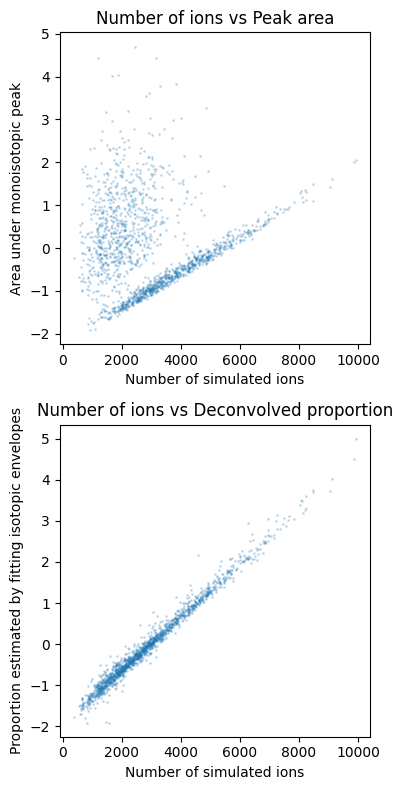

In [53]:
true_count_flat = true_ion_image[..., 1].flatten()
peak_area_flat = integrated_peak_areas[..., 1].flatten()
mass_estim_flat = estimated_lipid_signals[..., 1].flatten()
plt.figure(figsize=(4,8))
plt.subplot(211)
plt.scatter(true_count_flat, peak_area_flat, s=1, alpha=0.2)
plt.title('Number of ions vs Peak area')
plt.xlabel('Number of simulated ions')
plt.ylabel('Area under monoisotopic peak')
plt.subplot(212)
plt.scatter(true_count_flat, mass_estim_flat, s=1, alpha=0.2)
plt.title('Number of ions vs Deconvolved proportion')
plt.xlabel('Number of simulated ions')
plt.ylabel('Proportion estimated by fitting isotopic envelopes')
plt.tight_layout()

## Saving the results

Save the table of lipid formulas used in the simulation and their monoisotopic peaks:

In [36]:
with open('lipid_table.tsv', 'w') as h:
    h.write('\t'.join(['Name', 'Formula', 'Monoisotopic mass']) + '\n')
    for s in spectra:
        h.write(s.label + '\t' + s.formula + '\t' + str(s.confs[0][0]) + '\n')

Save the image in profile mode in imzML:

In [37]:
with ImzMLWriter('lipid_MSI_profile_mode.imzML') as writer:
    for i in range(mask.shape[0]):
        if not i % 50:
            print(i)
        for j in range(mask.shape[1]):
            writer.addSpectrum(mass_axis, image[i,j,:], (j, i))

0


Centroid the image and save it in imzML:

In [38]:
with ImzMLWriter('lipid_MSI_centroid_mode.imzML') as writer:
    for i in range(mask.shape[0]):
        if not i % 50:
            print(i)
        for j in range(mask.shape[1]):
            S = Spectrum(confs=list(zip(mass_axis, image[i,j,:])))
            peaks, _ = S.centroid(max_width = 0.4, peak_height_fraction=0.2)
            mzs = [p[0] for p in peaks]
            intsys = [p[1] for p in peaks]
            writer.addSpectrum(mzs, intsys, (j, i))

0


Save the deconvolved ion images in .imzML:

In [39]:
mass_axis = [s.confs[0][0] for s in spectra]
mass_axis_order = sorted(range(len(mass_axis)), key = lambda i: mass_axis[i])
sorted_mass_axis = [mass_axis[i] for i in mass_axis_order]

with ImzMLWriter('lipid_MSI_deconvolved.imzML' % n) as writer:
    for i in range(mask.shape[0]):
        for j in range(mask.shape[0]):
            sorted_intensity = [estimated_lipid_signals[i,j,iid] for iid in mass_axis_order]
            writer.addSpectrum(sorted_mass_axis, sorted_intensity, (j, i))

Save the results of regression of spectra as a table:

In [40]:
with open('lipid_regression_results.tsv', 'w') as h:
    h.write('\t'.join(['X', 'Y']+lipid_names) + '\n')
    for x_coord in range(estimated_lipid_signals.shape[1]):
        for y_coord in range(estimated_lipid_signals.shape[0]):
            h.write('\t'.join(map(str, (x_coord, y_coord))))
            h.write('\t')
            h.write('\t'.join(map(str, estimated_lipid_signals[y_coord, x_coord, ...])))
            h.write('\n')